In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os
import pickle
import matplotlib.pyplot as plt
import vehicle_list_data

# Sort Pickles

In [2]:
file_path = "trials/MOST_RECENT_natalie_updated/"
pkls = os.listdir(file_path)
num_scenarios = 5
per_scenario = {str(n):[] for n in range(num_scenarios)}
for scenario in range(num_scenarios):
    for pkl in pkls:
        end_index = pkl.find('_algorithm_')
        if "scenario_"+str(scenario) in pkl or pkl[end_index-1:end_index]==str(scenario):
            per_scenario[str(scenario)].append(pkl)

per_scenario = {key:sorted(per_scenario[key]) for key in per_scenario}
per_scenario

{'0': ['natalie_updated_0_algorithm_1_05_02_2022_12_02_55.pkl',
  'natalie_updated_0_algorithm_2_05_02_2022_12_03_25.pkl',
  'natalie_updated_0_algorithm_3_05_02_2022_12_03_55.pkl',
  'natalie_updated_0_algorithm_4_05_02_2022_12_04_25.pkl',
  'natalie_updated_0_algorithm_5_05_02_2022_12_04_54.pkl'],
 '1': ['natalie_updated_1_algorithm_1_05_02_2022_12_06_00.pkl',
  'natalie_updated_1_algorithm_2_05_02_2022_12_06_31.pkl',
  'natalie_updated_1_algorithm_3_05_02_2022_12_07_02.pkl',
  'natalie_updated_1_algorithm_4_05_02_2022_12_07_34.pkl',
  'natalie_updated_1_algorithm_5_05_02_2022_12_08_06.pkl'],
 '2': ['natalie_updated_2_algorithm_1_05_02_2022_12_09_08.pkl',
  'natalie_updated_2_algorithm_2_05_02_2022_12_09_41.pkl',
  'natalie_updated_2_algorithm_3_05_02_2022_12_10_14.pkl',
  'natalie_updated_2_algorithm_4_05_02_2022_12_10_49.pkl',
  'natalie_updated_2_algorithm_5_05_02_2022_12_11_21.pkl'],
 '3': ['natalie_updated_3_algorithm_1_05_02_2022_12_12_22.pkl'],
 '4': ['natalie_updated_4_algori

# Graph Scenarios over Algorithm Iterations

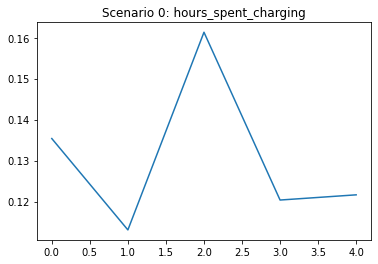

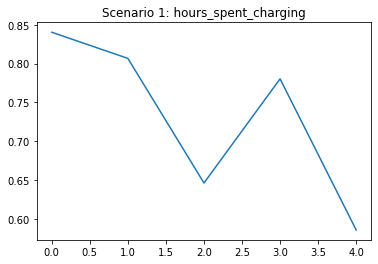

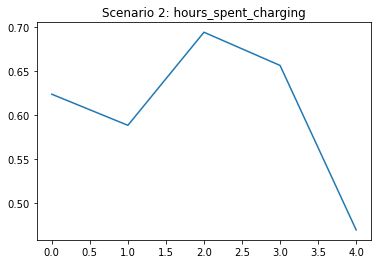

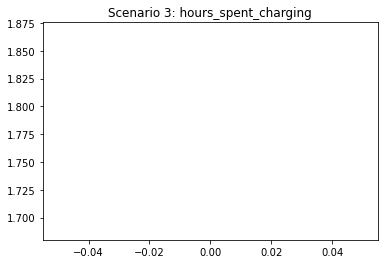

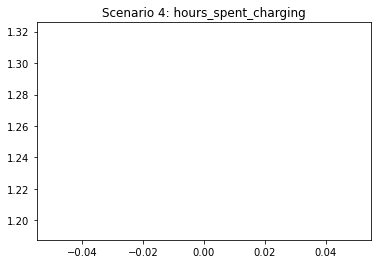

In [4]:
def graph_scenario(n, metric = "station_utilization_disp_of_avg", measurement=None):
    indices = {"min": 0, "med": 1, "max": 2, "mean": 3, "std":4}
    data = []
    for pkl in per_scenario[str(n)]:
        with open(file_path + pkl, 'rb') as inp:
            res = pickle.load(inp)
            if measurement != None:
                data.append(res.metrics[metric][indices[measurement]])
            else:
                data.append(res.metrics[metric])
    plt.plot(data)
    plt.title("Scenario " + str(n) + ": " + metric)
    plt.show()

for scenario in range(num_scenarios):
    graph_scenario(scenario, metric = "hours_spent_charging", measurement = "mean")

# Extract Charging Station Information

In [26]:
def extract_utilized_charging_stations(path):
    stations_used = []
    stations_passed = []
    for i, loc in enumerate(path):
        if i == len(path):
            break
        if "_in" in loc:
            next_loc = path[i+1]
            in_battery = loc.split("_")[1]
            out_battery = next_loc.split("_")[1]
            if "_out" in next_loc:
                node = loc.split("_")[0]
                if in_battery != out_battery:
                    stations_used.append(node)
                else:
                    stations_passed.append(node)
    return (stations_used, stations_passed)

In [62]:
sim_index = "0"
alg_index = 0
with open(file_path + per_scenario[sim_index][alg_index], 'rb') as inp:
    sim = pickle.load(inp)
        
station_used_counts = {node:0 for node in sim.station_g.nodes}
station_passed_counts = {node:0 for node in sim.station_g.nodes}

for vehicle in sim.vehicle_list:
    stations_used, stations_passed = extract_utilized_charging_stations(vehicle.path)
    for station in stations_used:
        station_used_counts[station]+=1
    for station in stations_passed:
        station_passed_counts[station]+=1
utilization_data = np.array([list(station_used_counts.keys()), list(station_used_counts.values()), list(station_passed_counts.values())]).T
utilization_df = pd.DataFrame(utilization_data, columns = ["node", "used", "passed"])
utilization_df = utilization_df.astype({"used": int, "passed": int})
utilization_df.head(5)

,node,used,passed
0,2,0,0
1,3,237,0
2,4,0,0
3,5,416,1349
4,6,48,0


In [70]:
num_stations_unseen = len(utilization_df.loc[(utilization_df["used"]==0)&(utilization_df["passed"]==0)])
num_stations_passed = len(utilization_df.loc[(utilization_df["used"]==0)&(utilization_df["passed"]!=0)])
num_stations_charging = len(utilization_df.loc[(utilization_df["used"]!=0)])

print(num_stations_charging, num_stations_passed, num_stations_unseen)

12 7 24


# Assess Demand

['Oakland', 'Long Beach', 'San Diego', 'Fresno', 'Sacramento', 'Reno', 'Oregon']


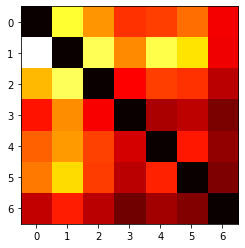

In [80]:
sim_index = "0"
alg_index = 0
with open(file_path + per_scenario[sim_index][alg_index], 'rb') as inp:
    sim = pickle.load(inp)
        
demand_nodes = list(sim.dst_dict.keys())
num_demand_nodes = len(demand_nodes)
destinations = {dst:0 for dst in demand_nodes}
sources = {src:0 for src in demand_nodes}
paths = {(src, dst):0 for src in demand_nodes for dst in demand_nodes}

for vehicle in sim.vehicle_list:
    destinations[vehicle.dst]+=1
    sources[vehicle.src]+=1
    paths[(vehicle.src, vehicle.dst)] +=1

paths
path_matrix = np.zeros((num_demand_nodes,num_demand_nodes))
for r, src in enumerate(demand_nodes):
    for c, dst in enumerate(demand_nodes):
        path_matrix[r][c] = paths[(src,dst)]

['Oakland', 'Long Beach', 'San Diego', 'Fresno', 'Sacramento', 'Reno', 'Oregon']


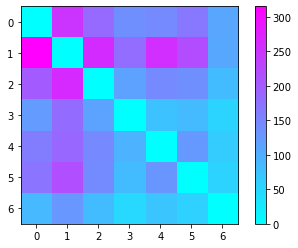

In [84]:
plt.imshow(path_matrix, cmap='cool', interpolation='nearest')
print(demand_nodes)
plt.colorbar()
plt.show()

In [88]:
nx.shortest_path(sim.station_demand_g, "Oakland", "Long Beach")

['Oakland', '41', '26', 'Long Beach']